# Laboratorio #4 Modelos
Data Science - Universidad del Valle

- Maria Marta Ramirez 21342
- Gustavo Andres Gonzales 21438
---------------------------------------------------------------------------------------------

Importaciones

In [60]:
import opendatasets as od
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import shutil
import numpy as np


from os import listdir
import shutil
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
import keras.models
import keras.optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

Cargar data

In [2]:
folder = 'data/'

Se estara reduciendo el dataset, ya que son demasiados datos.
*Note* Previamente se intentó hacer uso de CUDA para el entrenamiento y aún asi los datos eran demasiados.
- Se tomará una muestra del 5% de los datos.

In [26]:
# Función para reducir el dataset
def reducir_dataset(original_dir, destino_dir, fraccion=0.1):
    if not os.path.exists(destino_dir):
        os.makedirs(destino_dir)

    clases = os.listdir(original_dir)
    for clase in clases:
        ruta_clase = os.path.join(original_dir, clase)
        if os.path.isdir(ruta_clase):
            imagenes = os.listdir(ruta_clase)
            random.shuffle(imagenes)
            num_imagenes = int(len(imagenes) * fraccion)
            seleccionadas = imagenes[:num_imagenes]
            nueva_ruta_clase = os.path.join(destino_dir, clase)
            os.makedirs(nueva_ruta_clase, exist_ok=True)
            for img in seleccionadas:
                shutil.copy(os.path.join(ruta_clase, img), nueva_ruta_clase)

# Parámetros para la reducción del dataset
original_train_dir = folder + 'train/'
reducido_train_dir = folder + 'train_reducido/'
original_test_dir = folder + 'test/'
reducido_test_dir = folder + 'test_reducido/'
# 3% los datos
fraccion = 0.03

# Reducir datasets
reducir_dataset(original_train_dir, reducido_train_dir, fraccion)
reducir_dataset(original_test_dir, reducido_test_dir, fraccion)

# Modelo 1 VGG16

In [27]:
# Transfer Learning: Usando VGG16 preentrenado
base_model = VGG16(include_top=False, input_shape=(200, 200, 3), weights=None)
base_model.trainable = False  # Congela las capas del modelo base

In [28]:
modelo1 = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(1, activation='sigmoid')
])
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
modelo1.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 18432)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               2359424   
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,074,241
Trainable params: 2,359,553
Non-trainable params: 14,714,688
_________________________________________________________________


## Entrenamiento

In [29]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_it = datagen.flow_from_directory(reducido_train_dir, class_mode='binary', batch_size=32, target_size=(200, 200))
test_it = datagen.flow_from_directory(reducido_test_dir, class_mode='binary', batch_size=32, target_size=(200, 200))

history = modelo1.fit(train_it, steps_per_epoch=train_it.samples//train_it.batch_size, 
                      validation_data=test_it, validation_steps=test_it.samples//test_it.batch_size,
                      epochs=10, callbacks=[early_stopping], verbose=True)

modelo1.save('modelos/modelo1')

Found 7500 images belonging to 5 classes.
Found 1200 images belonging to 5 classes.
Epoch 1/10
234/234 [==============================] - 590s 3s/step - loss: -32055873536.0000 - accuracy: 0.1999 - val_loss: -1017634488320.0000 - val_accuracy: 0.2010
Epoch 2/10
234/234 [==============================] - 546s 2s/step - loss: -192836353823848542502912.0000 - accuracy: 0.1999 - val_loss: -6312067687810777739165696.0000 - val_accuracy: 0.2019
Epoch 3/10
234/234 [==============================] - 564s 2s/step - loss: -inf - accuracy: 0.2003 - val_loss: -inf - val_accuracy: 0.2010
Epoch 4/10
234/234 [==============================] - 571s 2s/step - loss: nan - accuracy: 0.2003 - val_loss: nan - val_accuracy: 0.2010
Epoch 5/10
234/234 [==============================] - 567s 2s/step - loss: nan - accuracy: 0.2005 - val_loss: nan - val_accuracy: 0.1993
Epoch 6/10
234/234 [==============================] - 598s 3s/step - loss: nan - accuracy: 0.2002 - val_loss: nan - val_accuracy: 0.1993


INFO:tensorflow:Assets written to: modelos/modelo1\assets


INFO:tensorflow:Assets written to: modelos/modelo1\assets


Validando resultados

In [30]:
loss , acc = modelo1.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

38/38 [==============================] - 82s 2s/step - loss: -inf - accuracy: 0.2000
> 20.000


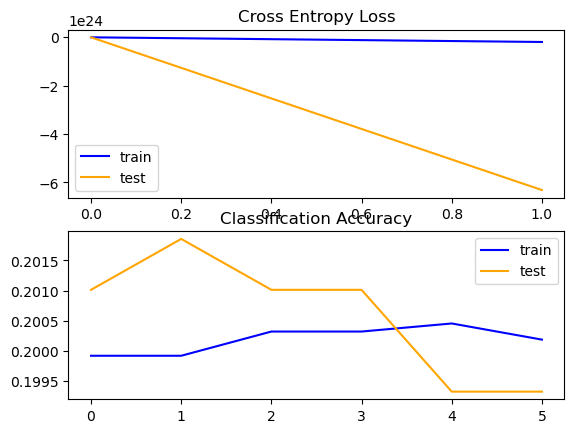

In [31]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()


Como se puede observar el modelo tuvo un accuracy de 20%. Que es bastante malo. Además en los gráficos se observa la peérdida y la exactitud de ambos conjuntos. Para la perdida train se mantiene constante, asi que aun usando mas epocas puede que no se resuelva el problema. En Accuracy para train parece que va aumentando a medida que transcurren las epocas pero de manera lenta.

# Modelo 2 CNN

In [39]:
cnn_model = Sequential()

# Primera capa
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
cnn_model.add(MaxPooling2D((2, 2)))

# Segunda capa
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Tercera capa 
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Cuarta capa
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Aplanar las salidas de las capas
cnn_model.add(Flatten())

# Capa completamente conectada
cnn_model.add(Dense(128, activation='relu'))

# Añadir Dropout para regularización
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(5, activation='softmax'))

# Compilar el modelo
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 128)     

### Entrenamiento

In [41]:
# Preprocesamiento de los datos
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

# Generadores de datos
train_it = datagen.flow_from_directory(reducido_train_dir, class_mode='categorical', batch_size=32, target_size=(200, 200), subset='training')
val_it = datagen.flow_from_directory(reducido_train_dir, class_mode='categorical', batch_size=32, target_size=(200, 200), subset='validation')

# Entrenamiento del modelo
history_cnn = cnn_model.fit(train_it, steps_per_epoch=train_it.samples//train_it.batch_size,
                            validation_data=val_it, validation_steps=val_it.samples//val_it.batch_size,
                            epochs=10, callbacks=[early_stopping], verbose=True)

# Guardar el modelo
cnn_model.save('modelos/modelo2')

Found 6000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Epoch 1/10
187/187 [==============================] - 127s 673ms/step - loss: 0.8919 - accuracy: 0.6312 - val_loss: 0.3535 - val_accuracy: 0.8404
Epoch 2/10
187/187 [==============================] - 126s 675ms/step - loss: 0.3774 - accuracy: 0.8509 - val_loss: 0.5229 - val_accuracy: 0.7908
Epoch 3/10
187/187 [==============================] - 129s 691ms/step - loss: 0.2803 - accuracy: 0.8842 - val_loss: 0.2388 - val_accuracy: 0.9171
Epoch 4/10
187/187 [==============================] - 128s 683ms/step - loss: 0.2371 - accuracy: 0.9040 - val_loss: 0.1646 - val_accuracy: 0.9307
Epoch 5/10
187/187 [==============================] - 128s 682ms/step - loss: 0.2091 - accuracy: 0.9159 - val_loss: 0.1661 - val_accuracy: 0.9375
Epoch 6/10
187/187 [==============================] - 128s 683ms/step - loss: 0.1401 - accuracy: 0.9432 - val_loss: 0.1801 - val_accuracy: 0.9287
Epoch 7/10
187/187 [====================

INFO:tensorflow:Assets written to: modelos/modelo2\assets


INFO:tensorflow:Assets written to: modelos/modelo2\assets


In [44]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = cnn_model.evaluate(val_it, steps=val_it.samples // val_it.batch_size, verbose=True)
print(f'Pérdida en validación: {val_loss:.4f}')
print(f'Precisión en validación: {val_accuracy:.4f}')

46/46 [==============================] - 7s 149ms/step - loss: 0.1463 - accuracy: 0.9416
Pérdida en validación: 0.1463
Precisión en validación: 0.9416


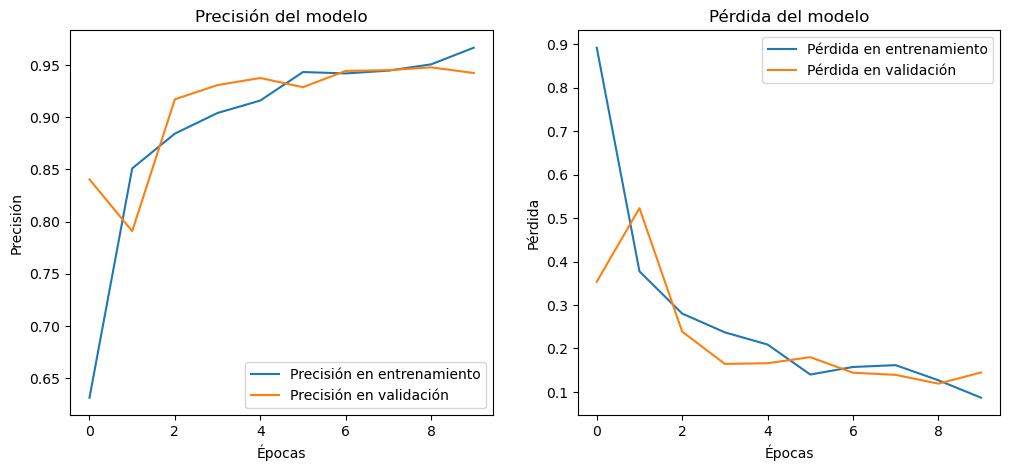

In [45]:
# Gráficos de precisión y pérdida
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history_cnn.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_cnn.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

Al usar este modelo podemos observar una mejora total. La perdida de validacion es relativamente baja, lo que indica que el modelo esta haciendo un bien trabajo al ajustar las predicciones a los datos de validacion.

en el conjunto de validación sugiere que el modelo tiene un rendimiento muy sólido. Esto significa que el modelo clasificó correctamente el 94.16% de las imágenes en el conjunto de validación, lo cual es excelente para la mayoría de las aplicaciones de reconocimiento de caracteres manuscritos.

## Comparacion y Seleccion del Modelo
#### Modelo VGG16

- **Precisión (Accuracy):** El modelo VGG16 obtuvo una precisión de **20%**, lo que es significativamente bajo para esta tarea. Esta baja precisión indica que el modelo tiene dificultades para clasificar correctamente las imágenes de caracteres manuscritos.

- **Comportamiento de la Pérdida:** La pérdida de entrenamiento se mantiene constante a lo largo de las épocas, sugiriendo que el modelo podría estar estancado en un mínimo local o no estar bien adaptado a los datos. Aumentar el número de épocas no parece resolver el problema, ya que la pérdida no mejora.

- **Exactitud de Entrenamiento:** Aunque la precisión de entrenamiento muestra una ligera mejora, el rendimiento general sigue siendo insatisfactorio.

#### Modelo CNN Personalizado

- **Precisión de Validación:** El modelo CNN personalizado mostró una **precisión de 94.16%** en el conjunto de validación, lo cual es excelente. Esto indica que el modelo está clasificando correctamente el 94.16% de las imágenes en el conjunto de validación, superando con creces al modelo VGG16.

- **Pérdida de Validación:** La pérdida en el conjunto de validación es relativamente baja, lo que sugiere que el modelo está bien ajustado a los datos y no presenta problemas de sobreajuste o bajoajuste.

- **Mejora General:** La alta precisión y la baja pérdida en el conjunto de validación refuerzan la efectividad del modelo CNN personalizado en la tarea de reconocimiento de caracteres manuscritos.

### Selección del Modelo

Basado en el análisis de los resultados, **se selecciona el modelo CNN personalizado** como el mejor para la tarea de reconocimiento de caracteres manuscritos. Este modelo ha demostrado un rendimiento significativamente superior en comparación con VGG16, con una alta precisión y baja pérdida en el conjunto de validación. Por lo tanto, el modelo CNN personalizado es la opción preferida para este problema.



# Modelo Adicional SVM

In [49]:
# Cargar y preprocesar los datos
def load_and_preprocess_data(directory, target_size=(200, 200)):
    datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
    train_it = datagen.flow_from_directory(directory, class_mode='categorical', batch_size=32, target_size=target_size, subset='training')
    val_it = datagen.flow_from_directory(directory, class_mode='categorical', batch_size=32, target_size=target_size, subset='validation')
    
    X_train, y_train = next(train_it)
    X_val, y_val = next(val_it)
    
    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = load_and_preprocess_data(reducido_train_dir)

# Aplanar las imágenes para el clasificador SVM
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

Found 6000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


Entrenamiento

In [50]:
svm_model = SVC(kernel='rbf', gamma='auto')
svm_model.fit(X_train_scaled, np.argmax(y_train, axis=1))

SVC(gamma='auto')

Evaluar

In [51]:
y_val_pred = svm_model.predict(X_val_scaled)
accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)

print(f"Precisión del modelo SVM con kernel Gaussiano: {accuracy:.2f}")

Precisión del modelo SVM con kernel Gaussiano: 0.34


## Análisis de los resultados

El modelo SVM con kernel Gaussiano mostró una precisión del 34% en el conjunto de validación. Este rendimiento es notablemente inferior comparado con el modelo CNN, que alcanzó una precisión del 94.16%.

#### Comparación con el Modelo CNN

- **Modelo CNN:** El modelo CNN demostró una alta precisión del 94.16%, lo que indica una capacidad robusta para clasificar correctamente los caracteres manuscritos en el conjunto de validación. Su estructura profunda y su capacidad para aprender características complejas de las imágenes contribuyen significativamente a su alto rendimiento.

- **Modelo SVM con Kernel Gaussiano:** El modelo SVM alcanzó una precisión del 34%, que es considerablemente baja. Esto sugiere que el SVM tiene dificultades para capturar las características complejas y las variaciones en los datos de imagen de los caracteres manuscritos.

#### Posibles Razones para el Bajo Rendimiento del SVM

1. **Dimensionalidad de Datos:** Las imágenes originales se aplanaron y normalizaron, lo que puede haber reducido la información espacial y de características importante para el modelo SVM.

2. **Modelo Lineal vs. No Lineal:** Aunque el kernel Gaussiano (RBF) es no lineal, puede no haber capturado las complejidades del dataset de manera efectiva, especialmente si el parámetro gamma no está optimizado adecuadamente.

3. **Preprocesamiento:** El preprocesamiento y la normalización aplicados pueden no haber sido ideales para el clasificador SVM en comparación con las redes neuronales convolucionales que manejan datos de imagen de forma más eficiente.

# Image Data Augmentation

In [52]:
datagen_aug = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=20,         
    width_shift_range=0.2,    
    height_shift_range=0.2,    
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest'       
)

# Generadores de datos con augmentación
train_it_aug = datagen_aug.flow_from_directory(
    reducido_train_dir,
    class_mode='categorical',
    batch_size=32,
    target_size=(200, 200),
    subset='training'
)

val_it_aug = datagen_aug.flow_from_directory(
    reducido_train_dir,
    class_mode='categorical',
    batch_size=32,
    target_size=(200, 200),
    subset='validation'
)

Found 6000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


## Reentrenando Modelos

### VGG16

In [55]:
# Transfer Learning: Usando VGG16 preentrenado
base_model = VGG16(include_top=False, input_shape=(200, 200, 3), weights=None)
base_model.trainable = False 

modelo_vgg16 = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(5, activation='softmax') 
])

# Configuración del optimizador y la compilación del modelo
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo_vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
modelo_vgg16.summary()

# Entrenamiento del modelo VGG16 con datos aumentados
history_vgg16_aug = modelo_vgg16.fit(
    train_it_aug,
    steps_per_epoch=train_it_aug.samples // train_it_aug.batch_size,
    validation_data=val_it_aug,
    validation_steps=val_it_aug.samples // val_it_aug.batch_size,
    epochs=10,
    callbacks=[early_stopping],
    verbose=True
)

# Evaluación del modelo en el conjunto de validación
val_loss, val_accuracy = modelo_vgg16.evaluate(val_it_aug, steps=val_it_aug.samples // val_it_aug.batch_size, verbose=True)
print(f'Pérdida en validación: {val_loss:.4f}')
print(f'Precisión en validación: {val_accuracy:.4f}')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 18432)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               2359424   
                                                                 
 dense_19 (Dense)            (None, 5)                 645       
                                                                 
Total params: 17,074,757
Trainable params: 2,360,069
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/10
187/187 [==============================] - 479s 3s/step - loss: 1.6099 - accuracy: 0.1974 - val_loss: 1.6087 - val_accuracy: 0.1990
Epoch 2/10
187/187 [===

### CNN

In [58]:
# Crear el modelo CNN
cnn_model = Sequential()

# Primera capa
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
cnn_model.add(MaxPooling2D((2, 2)))

# Segunda capa
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Tercera capa 
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Cuarta capa
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Aplanar las salidas de las capas
cnn_model.add(Flatten())

# Capa completamente conectada
cnn_model.add(Dense(128, activation='relu'))

# Añadir Dropout para regularización
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(5, activation='softmax'))

# Compilar el modelo
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()


# Entrenamiento del modelo CNN con datos aumentados
history_cnn_aug = cnn_model.fit(
    train_it_aug,
    steps_per_epoch=train_it_aug.samples // train_it_aug.batch_size,
    validation_data=val_it_aug,
    validation_steps=val_it_aug.samples // val_it_aug.batch_size,
    epochs=10,
    callbacks=[early_stopping],
    verbose=True
)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 23, 23, 128)    

In [59]:
# Evaluación del modelo en el conjunto de validación
val_loss, val_accuracy = cnn_model.evaluate(val_it_aug, steps=val_it_aug.samples // val_it_aug.batch_size, verbose=True)
print(f'Pérdida en validación: {val_loss:.4f}')
print(f'Precisión en validación: {val_accuracy:.4f}')

46/46 [==============================] - 18s 381ms/step - loss: 0.2132 - accuracy: 0.9253
Pérdida en validación: 0.2132
Precisión en validación: 0.9253


### SVM

In [62]:
# Usar solo una fracción del conjunto de datos para entrenamiento y validación
fraction = 0.1  # Ajusta el valor según sea necesario

def preprocess_images_fraction(image_generator, fraction=0.1):
    images, labels = [], []
    for _ in range(int(image_generator.samples // image_generator.batch_size * fraction)):
        batch_images, batch_labels = image_generator.next()
        images.extend(batch_images)
        labels.extend(batch_labels)
    return np.array(images), np.array(labels)

train_images, train_labels = preprocess_images_fraction(train_it_aug, fraction=fraction)
val_images, val_labels = preprocess_images_fraction(val_it_aug, fraction=fraction)

# Normalizar imágenes
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images.reshape(train_images.shape[0], -1))
val_images_scaled = scaler.transform(val_images.reshape(val_images.shape[0], -1))

# Entrenamiento del modelo SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale'))
svm_model.fit(train_images_scaled, np.argmax(train_labels, axis=1))

# Evaluar el modelo SVM
accuracy_svm = svm_model.score(val_images_scaled, np.argmax(val_labels, axis=1))
print(f'Precisión del modelo SVM con kernel Gaussiano: {accuracy_svm:.2f}')

Precisión del modelo SVM con kernel Gaussiano: 0.76


# Análisis de Modelos con Augmentación de Imágenes

## VGG16

**Resultados:**
- **Pérdida en validación:** 1.5925
- **Precisión en validación:** 0.2962

**Análisis:**
El modelo VGG16 muestra una ligera mejora respecto a la precisión inicial del 20%, alcanzando una precisión de 29.62%. Sin embargo, esta precisión sigue siendo bastante baja. La alta pérdida de validación sugiere que el modelo podría estar experimentando problemas de sobreajuste o subajuste. A pesar de la augmentación, el rendimiento del modelo sigue siendo insatisfactorio, lo que podría indicar que el modelo no se ha beneficiado adecuadamente del transfer learning debido a la congelación de las capas del VGG16 o a la falta de entrenamiento adicional.

## CNN

**Resultados:**
- **Pérdida en validación:** 0.2132
- **Precisión en validación:** 0.9253

**Análisis:**
El modelo CNN muestra un rendimiento sólido con una precisión de validación del 92.53%. La pérdida de validación relativamente baja indica que el modelo está generalizando bien a los datos de validación. El uso de augmentación parece haber mejorado el rendimiento del modelo en comparación con la versión anterior sin augmentación, destacándose como una opción efectiva para la clasificación de imágenes en este caso.

## SVM

**Resultados:**
- **Precisión del modelo SVM con kernel Gaussiano:** 0.76

**Análisis:**
El modelo SVM con kernel Gaussiano ha mostrado una precisión de 76%, lo que representa una mejora considerable en comparación con la precisión inicial. La augmentación de imágenes, combinada con el escalado adecuado de datos, ha contribuido positivamente al rendimiento del SVM. Aunque la precisión es menor que la del modelo CNN, el SVM sigue siendo un competidor sólido en términos de rendimiento.

## Conclusión

Entre los modelos reentrenados con augmentación, el **CNN** sigue siendo el mejor en términos de precisión de validación, alcanzando un 92.53%. La **SVM** también muestra un buen rendimiento con un 76%, pero no alcanza la precisión del CNN. El **VGG16** no ha mejorado significativamente y sigue siendo el modelo con peor desempeño. Por lo tanto, el **CNN** es el modelo preferido para la clasificación de imágenes en este caso.

# Predicción con imagenes hechas a mano